# **Predicción de precios en Airbnb**

En este proyecto analizamos el dataset `AB_US_2023.csv`, que contiene anuncios de
Airbnb en distintas ciudades de Estados Unidos. El objetivo principal es:

- Explorar el comportamiento de los precios.
- Identificar variables relevantes que explican la variación de precio.
- Construir modelos de regresión capaces de predecir el precio de un anuncio
  a partir de sus características (texto, ubicación, tipo de habitación, etc.).

Trabajaremos en Python usando Google Colab y librerías estándar de Ciencia de Datos
(pandas, numpy, matplotlib, seaborn, scikit-learn y XGBoost, Lasso, Ridge, ...).


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use("seaborn-v0_8")
sns.set_palette("rocket")

# Carga del dataset (ajustar ruta si hace falta)
df = pd.read_csv("AB_US_2023.csv")

print("Dimensión del dataset:", df.shape)
df.head()


Dimensión del dataset: (232147, 18)


/tmp/ipython-input-3808477728.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("AB_US_2023.csv")


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",1169,Holly,NaN,Western Addition,37.77028,-122.43317,Entire home/apt,202,2,383,2023-02-19,2.31,1,128,59,San Francisco
1,5858,Creative Sanctuary,8904,Philip And Tania,NaN,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,2017-08-06,0.66,1,365,0,San Francisco
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,NaN,Haight Ashbury,37.76555,-122.45213,Private room,56,32,9,2022-10-27,0.09,13,365,1,San Francisco
3,8339,Historic Alamo Square Victorian,24215,Rosy,NaN,Western Addition,37.77564,-122.43642,Entire home/apt,575,9,28,2019-06-28,0.17,2,365,0,San Francisco
4,8739,"Mission Sunshine, with Private Bath",7149,Ivan & Wendy,NaN,Mission,37.76030,-122.42197,Private room,110,1,770,2023-02-25,4.65,2,159,34,San Francisco


## **2. Selección de variables relevantes**

El dataset original contiene muchas columnas. Para este proyecto nos
concentramos en un subconjunto que describe:

- Identidad del anuncio (`id`, `name`).
- Ubicación (`city`, `neighbourhood`, `latitude`, `longitude`).
- Tipo de alojamiento (`room_type`).
- Atributos de operación (`minimum_nights`, `availability_365`,
  `number_of_reviews`, `reviews_per_month`,
  `calculated_host_listings_count`).
- Variable objetivo: `price`.

Primero filtramos estas columnas y revisamos valores faltantes.


In [ ]:
cols = [
    "id", "name", "neighbourhood", "latitude", "longitude",
    "room_type", "price", "minimum_nights", "number_of_reviews",
    "reviews_per_month", "calculated_host_listings_count",
    "availability_365", "city"
]

data = df[cols].copy()

data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232147 entries, 0 to 232146
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              232147 non-null  int64  
 1   name                            232131 non-null  object 
 2   neighbourhood                   232147 non-null  object 
 3   latitude                        232147 non-null  float64
 4   longitude                       232147 non-null  float64
 5   room_type                       232147 non-null  object 
 6   price                           232147 non-null  int64  
 7   minimum_nights                  232147 non-null  int64  
 8   number_of_reviews               232147 non-null  int64  
 9   reviews_per_month               183062 non-null  float64
 10  calculated_host_listings_count  232147 non-null  int64  
 11  availability_365                232147 non-null  int64  
 12  city            

,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,city
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",Western Addition,37.77028,-122.43317,Entire home/apt,202,2,383,2.31,1,128,San Francisco
1,5858,Creative Sanctuary,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,0.66,1,365,San Francisco
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,Haight Ashbury,37.76555,-122.45213,Private room,56,32,9,0.09,13,365,San Francisco
3,8339,Historic Alamo Square Victorian,Western Addition,37.77564,-122.43642,Entire home/apt,575,9,28,0.17,2,365,San Francisco
4,8739,"Mission Sunshine, with Private Bath",Mission,37.76030,-122.42197,Private room,110,1,770,4.65,2,159,San Francisco


## **3. Limpieza inicial y creación de la variable `state`**

Antes del análisis:

1. Observamos el porcentaje de valores faltantes.
2. Generamos una variable `state` a partir de la ciudad (`city`) usando un diccionario.
3. Eliminamos filas con valores faltantes en las columnas seleccionadas
   para simplificar el análisis.


In [ ]:
# Porcentaje de valores faltantes
missing_pct = data.isna().mean().sort_values(ascending=False) * 100
print("Porcentaje de valores faltantes:")
print(missing_pct)

# Mapear city -> state (diccionario aproximado)
states_dic = {
    'Asheville':'NC','Austin':'TX','Boston':'MA','Broward County':'FL','Cambridge':'MA',
    'Chicago':'IL','Clark County':'NV','Columbus':'OH','Denver':'CO','Hawaii':'HI',
    'Jersey City':'NJ','Los Angeles':'CA','Nashville':'TN','New Orleans':'LA',
    'New York City':'NY','Oakland':'CA','Pacific Grove':'CA','Portland':'OR',
    'Rhode Island':'RI','Salem':'MA','San Clara Country':'CA','Santa Cruz County':'CA',
    'San Diego':'CA','San Francisco':'CA','San Mateo County':'CA','Seattle':'WA',
    'Twin Cities MSA':'MN','Washington D.C.':'DC','Santa Clara County':'CA'
}

data["state"] = data["city"].map(states_dic)
data["state"] = data["state"].fillna("OTHER")

# Eliminar filas con NaN en las columnas que usaremos
data = data.dropna().reset_index(drop=True)
print("Shape después de dropna:", data.shape)

data.head()


Porcentaje de valores faltantes:
reviews_per_month                 21.143930
name                               0.006892
id                                 0.000000
latitude                           0.000000
neighbourhood                      0.000000
longitude                          0.000000
room_type                          0.000000
minimum_nights                     0.000000
price                              0.000000
number_of_reviews                  0.000000
calculated_host_listings_count     0.000000
availability_365                   0.000000
city                               0.000000
dtype: float64
Shape después de dropna: (183056, 14)


,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,city,state
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",Western Addition,37.77028,-122.43317,Entire home/apt,202,2,383,2.31,1,128,San Francisco,CA
1,5858,Creative Sanctuary,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,0.66,1,365,San Francisco,CA
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,Haight Ashbury,37.76555,-122.45213,Private room,56,32,9,0.09,13,365,San Francisco,CA
3,8339,Historic Alamo Square Victorian,Western Addition,37.77564,-122.43642,Entire home/apt,575,9,28,0.17,2,365,San Francisco,CA
4,8739,"Mission Sunshine, with Private Bath",Mission,37.76030,-122.42197,Private room,110,1,770,4.65,2,159,San Francisco,CA


## **4. Análisis exploratorio: distribución de precios**

Comenzamos estudiando la distribución de `price`. En muchos datasets de Airbnb
la distribución es muy asimétrica (muchos alojamientos baratos y pocos muy caros),
por lo que también analizamos el logaritmo del precio.


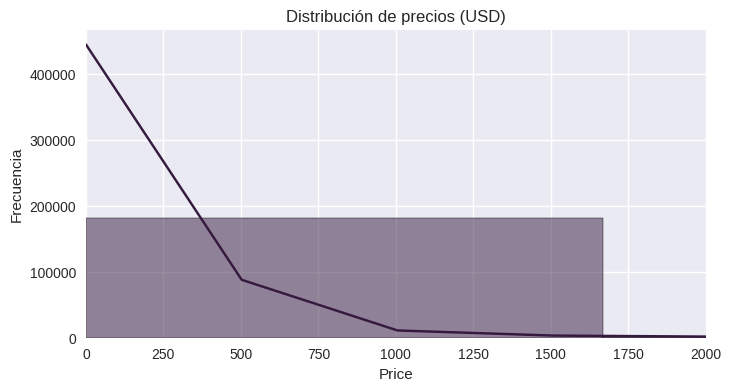

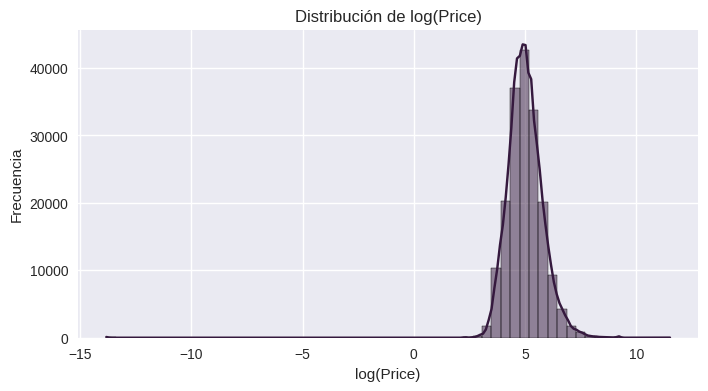

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(data["price"], bins=60, kde=True)
plt.title("Distribución de precios (USD)")
plt.xlim(0, 2000)
plt.xlabel("Price")
plt.ylabel("Frecuencia")
plt.show()

# Distribución en escala log
plt.figure(figsize=(8,4))
sns.histplot(np.log(data["price"] + 1e-6), bins=60, kde=True)
plt.title("Distribución de log(Price)")
plt.xlabel("log(Price)")
plt.ylabel("Frecuencia")
plt.show()


## **5. Precio por tipo de habitación y por ciudad**

Luego analizamos cómo cambia el precio según:

- El tipo de habitación (`room_type`).
- La ciudad (`city`).

Esto ayuda a visualizar patrones claros de mercado, como que los
"Entire home/apt" suelen ser más caros que "Private room", y que
ciertas ciudades (por ejemplo, San Francisco o Nueva York) presentan
niveles de precio mucho más altos que otras.


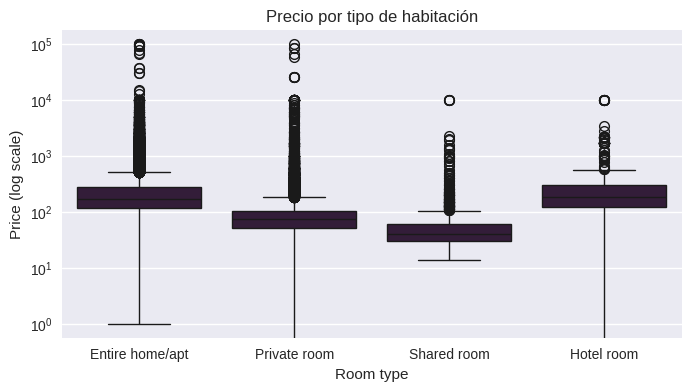

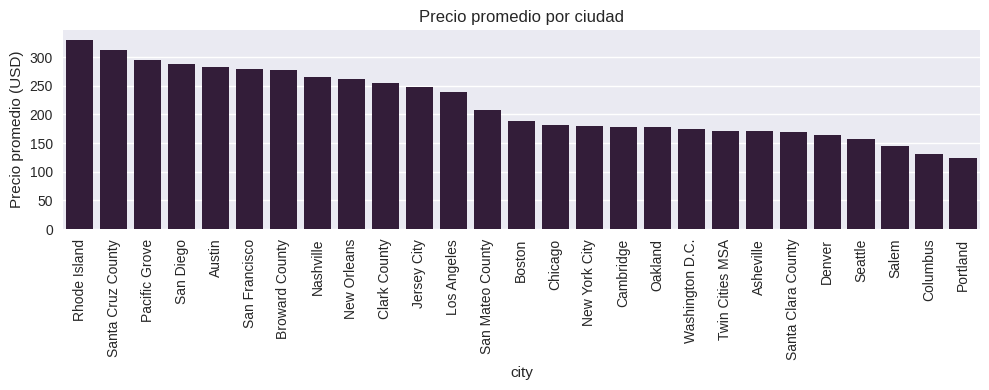

In [ ]:
# Boxplot de precio por tipo de habitación (escala log para ver mejor)
plt.figure(figsize=(8,4))
sns.boxplot(data=data, x="room_type", y="price")
plt.yscale("log")
plt.title("Precio por tipo de habitación")
plt.xlabel("Room type")
plt.ylabel("Price (log scale)")
plt.show()

# Precio promedio por ciudad (solo las más frecuentes)
plt.figure(figsize=(10,4))
city_price = (
    data.groupby("city")["price"]
    .mean()
    .sort_values(ascending=False)
)
sns.barplot(x=city_price.index, y=city_price.values)
plt.xticks(rotation=90)
plt.ylabel("Precio promedio (USD)")
plt.title("Precio promedio por ciudad")
plt.tight_layout()
plt.show()


## **6. Heatmap de densidad ponderado por precio**

Además del mapa de puntos, es útil visualizar **zonas de mayor concentración y precio**.
Para ello construimos un **heatmap** usando `folium.plugins.HeatMap`, donde:

- Cada anuncio aporta una “intensidad” al mapa.
- La intensidad está ponderada por el precio (precios más altos = mayor contribución).
- Las zonas más brillantes corresponden a áreas con muchos anuncios y/o precios elevados.

En este caso usamos un submuestreo para no saturar el mapa.


In [ ]:
!pip install folium

import folium
from folium.plugins import FastMarkerCluster

from folium.plugins import HeatMap

# Submuestreo para el heatmap
#sample_heat = data.sample(min(8000, len(data)), random_state=123)
sample_heat = data

# Normalizar el precio para usarlo como peso (opcional pero recomendable)
# Evita que unos pocos precios muy altos dominen todo el mapa
price_norm = (sample_heat["price"] - sample_heat["price"].min()) / (
    sample_heat["price"].max() - sample_heat["price"].min()
)
sample_heat = sample_heat.assign(price_weight=price_norm + 1e-3)  # evitar ceros exactos

# Centro del mapa
center_lat = sample_heat["latitude"].mean()
center_lon = sample_heat["longitude"].mean()

m_heat = folium.Map(location=[center_lat, center_lon], zoom_start=4, tiles="CartoDB positron")

# Preparar datos para HeatMap: [lat, lon, weight]
heat_data = [
    [row["latitude"], row["longitude"], row["price_weight"]]
    for idx, row in sample_heat.iterrows()
]

HeatMap(
    heat_data,
    radius=8,        # tamaño del "punto caliente"
    blur=10,         # suavizado
    max_zoom=10,     # hasta qué nivel de zoom influye
).add_to(m_heat)

m_heat


Output hidden; open in https://colab.research.google.com to view.

## **7. Filtrado de outliers**

Para evitar que unos pocos anuncios extremadamente caros o atípicos dominen el
entrenamiento, aplicamos un filtrado de outliers sobre varias variables:

- `price`: se recorta entre los percentiles 5% y 95%.
- `number_of_reviews`: se acota a menos de 200.
- `minimum_nights`: se limita a menos de 10 noches.
- `reviews_per_month`: se limita a menos de 5.
- `calculated_host_listings_count`: se descartan hosts con más de 10 anuncios.

Esto sigue la misma filosofía que muchos análisis de Airbnb: mantener la parte
"central" del mercado.


Shape después de filtrar outliers: (80052, 14)


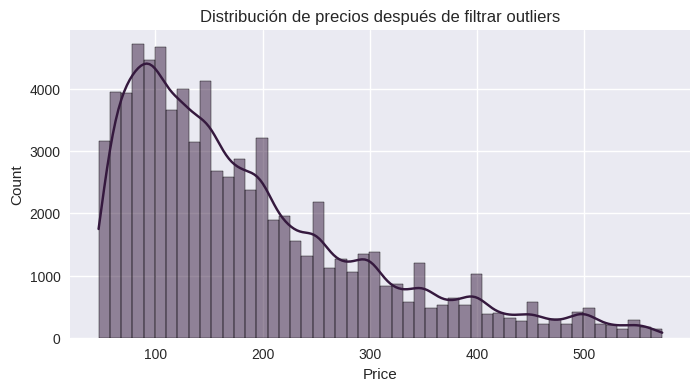

In [ ]:
df_filt = data.copy()

lower_q = 0.05
upper_q = 0.95

df_filt = df_filt[
    (df_filt["price"] >= df_filt["price"].quantile(lower_q)) &
    (df_filt["price"] <= df_filt["price"].quantile(upper_q)) &
    (df_filt["number_of_reviews"] > 0) &
    (df_filt["number_of_reviews"] < 200) &
    (df_filt["minimum_nights"] < 10) &
    (df_filt["reviews_per_month"] < 5) &
    (df_filt["calculated_host_listings_count"] < 10)
].reset_index(drop=True)

print("Shape después de filtrar outliers:", df_filt.shape)

plt.figure(figsize=(8,4))
sns.histplot(df_filt["price"], bins=50, kde=True)
plt.title("Distribución de precios después de filtrar outliers")
plt.xlabel("Price")
plt.show()


## **8. Definición de la variable objetivo y partición train/test**

Debido a la asimetría de los precios, utilizamos como variable objetivo
el logaritmo natural del precio:

$$
y = \log(\text{price})
$$

A continuación definimos el conjunto de variables explicativas y
dividimos los datos en entrenamiento (70%) y prueba (30%).


In [ ]:
df_model = df_filt.copy()

df_model["log_price"] = np.log(df_model["price"] + 1e-6)

feature_cols = [
    "name",
    "neighbourhood",
    "city",
    "state",
    "room_type",
    "latitude", "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
]

X = df_model[feature_cols]
y = df_model["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape


((56036, 12), (24016, 12))

## **9. Preprocesamiento: texto, numéricas y categóricas**

Nuestro conjunto de características es heterogéneo, así que construimos un
`ColumnTransformer` con tres ramas:

1. **Texto (`name`)**: se transforma con `TfidfVectorizer` (unigramas y bigramas,
   máximo 1000 términos, stopwords en inglés).
2. **Numéricas**: se escalan con `StandardScaler`.
3. **Categóricas**: se codifican mediante `OneHotEncoder`.

Este preprocesador se integrará después en un `Pipeline` junto con los modelos
de regresión.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

text_features = "name"

numeric_features = [
    "latitude", "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
]

categorical_features = [
    "neighbourhood",
    "city",
    "state",
    "room_type",
]

preprocessor = ColumnTransformer(
    transformers=[
        (
            "text",
            TfidfVectorizer(
                max_features=1000,
                ngram_range=(1, 2),
                stop_words="english"
            ),
            text_features
        ),
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


## **10. Modelo 1: Gradient Boosting Regressor**

Como primer modelo sobre el pipeline completo usamos
**GradientBoostingRegressor**, un ensamble de árboles poco profundos
entrenados secuencialmente. Entrenamos en la escala logarítmica del precio
y luego evaluamos tanto en log(precio) como en la escala original de dólares.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

gb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]
)

gb_pipeline.fit(X_train, y_train)

y_pred_log_gb = gb_pipeline.predict(X_test)

# Métricas en log
rmse_log_gb = np.sqrt(mean_squared_error(y_test, y_pred_log_gb))
mae_log_gb = mean_absolute_error(y_test, y_pred_log_gb)
r2_log_gb = r2_score(y_test, y_pred_log_gb)

# Métricas en escala de precio
y_test_price = np.exp(y_test)
y_pred_price_gb = np.exp(y_pred_log_gb)

rmse_gb = np.sqrt(mean_squared_error(y_test_price, y_pred_price_gb))
mae_gb = mean_absolute_error(y_test_price, y_pred_price_gb)

print("=== Gradient Boosting ===")
print(f"RMSE_log  : {rmse_log_gb:.4f}")
print(f"MAE_log   : {mae_log_gb:.4f}")
print(f"R²_log    : {r2_log_gb:.4f}")
print("-" * 40)
print(f"RMSE_precio: {rmse_gb:.2f}")
print(f"MAE_precio : {mae_gb:.2f}")

=== Gradient Boosting ===
RMSE_log  : 0.4263
MAE_log   : 0.3429
R²_log    : 0.4786
----------------------------------------
RMSE_precio: 91.02
MAE_precio : 63.10


## **11. Modelo 2: XGBoost Regressor**

A continuación probamos **XGBoost**, una implementación optimizada de
gradient boosting que suele ofrecer mejor desempeño en problemas tabulares.

Mantenemos el mismo preprocesamiento y comparamos resultados con el modelo
anterior.


In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

xgb_pipeline.fit(X_train, y_train)

y_pred_log_xgb = xgb_pipeline.predict(X_test)

rmse_log_xgb = np.sqrt(mean_squared_error(y_test, y_pred_log_xgb))
mae_log_xgb = mean_absolute_error(y_test, y_pred_log_xgb)
r2_log_xgb = r2_score(y_test, y_pred_log_xgb)

y_pred_price_xgb = np.exp(y_pred_log_xgb)

rmse_xgb = np.sqrt(mean_squared_error(y_test_price, y_pred_price_xgb))
mae_xgb = mean_absolute_error(y_test_price, y_pred_price_xgb)

print("=== XGBoost ===")
print(f"RMSE_log  : {rmse_log_xgb:.4f}")
print(f"MAE_log   : {mae_log_xgb:.4f}")
print(f"R²_log    : {r2_log_xgb:.4f}")
print("-" * 40)
print(f"RMSE_precio: {rmse_xgb:.2f}")
print(f"MAE_precio : {mae_xgb:.2f}")

=== XGBoost ===
RMSE_log  : 0.3974
MAE_log   : 0.3159
R²_log    : 0.5470
----------------------------------------
RMSE_precio: 85.21
MAE_precio : 58.52


##  **Función auxiliar de evaluación**

Para comparar modelos de forma homogénea definimos una función que:

1. Entrena el pipeline recibido.
2. Calcula métricas en escala logarítmica de precio.
3. Convierte las predicciones a escala original (USD) y calcula RMSE y MAE.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

def evaluar_pipeline(pipeline, X_train, y_train, X_test, y_test, nombre):
    """
    Entrena un pipeline en log(price) y devuelve un diccionario con métricas
    tanto en log como en la escala original de precio, incluyendo MAPE.
    """
    # 1. Entrenar modelo
    pipeline.fit(X_train, y_train)

    # 2. Predecir en escala logarítmica
    y_pred_log = pipeline.predict(X_test)

    # Métricas en log (útiles para el data scientist)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    r2_log = r2_score(y_test, y_pred_log)

    # 3. Transformar a escala original (Dólares)
    y_test_price = np.exp(y_test)
    y_pred_price = np.exp(y_pred_log)

    # Métricas en precio (útiles para el negocio)
    rmse_price = np.sqrt(mean_squared_error(y_test_price, y_pred_price))
    mae_price = mean_absolute_error(y_test_price, y_pred_price)

    # Cálculo del MAPE (multiplicamos por 100 para tener el porcentaje)
    mape_price = mean_absolute_percentage_error(y_test_price, y_pred_price) * 100

    print(f"=== {nombre} ===")
    print(f"RMSE (log)  : {rmse_log:.4f}")
    print(f"R² (log)    : {r2_log:.4f}")
    print("-" * 30)
    print(f"RMSE (USD)  : ${rmse_price:.2f}")
    print(f"MAE (USD)   : ${mae_price:.2f}")
    print(f"MAPE        : {mape_price:.2f}%  <-- Error porcentual promedio")
    print()

    return {
        "Modelo": nombre,
        "RMSE_log": rmse_log,
        "R2_log": r2_log,
        "RMSE_precio": rmse_price,
        "MAE_precio": mae_price,
        "MAPE": mape_price
    }

## **12. Modelo lineal regularizado: Ridge Regression (con GridSearchCV)**

Como primer modelo lineal probamos **Ridge Regression**, que añade una penalización
L2 a los coeficientes. Usamos `GridSearchCV` para buscar el mejor valor de
\(\alpha\) en una escala logarítmica, utilizando validación cruzada de 5 folds
y la métrica RMSE en log(price).


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold

# Pipeline base: preprocesador + modelo Ridge
ridge_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", Ridge())
    ]
)

param_grid_ridge = {
    "model__alpha": np.logspace(-3, 3, 7)  # 0.001, 0.01, ..., 1000
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_ridge = GridSearchCV(
    ridge_pipe,
    param_grid=param_grid_ridge,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_ridge.fit(X_train, y_train)

print("Mejores hiperparámetros Ridge:", grid_ridge.best_params_)
print("RMSE CV (log) Ridge:", -grid_ridge.best_score_)

best_ridge = grid_ridge.best_estimator_
metrics_ridge = evaluar_pipeline(best_ridge, X_train, y_train, X_test, y_test, "Ridge")


Mejores hiperparámetros Ridge: {'model__alpha': np.float64(10.0)}
RMSE CV (log) Ridge: 0.4103950209287617
=== Ridge ===
RMSE (log)  : 0.4071
R² (log)    : 0.5246
------------------------------
RMSE (USD)  : $85.86
MAE (USD)   : $59.48
MAPE        : 33.57%  <-- Error porcentual promedio



## **13. Modelo lineal esparso: Lasso Regression (con GridSearchCV)**

También probamos **Lasso Regression**, que utiliza penalización L1. Esta penalización
tiende a llevar algunos coeficientes exactamente a cero, lo que actúa como un mecanismo
de selección automática de variables. De nuevo utilizamos `GridSearchCV` para elegir
el mejor \(\alpha\).


In [ ]:
from sklearn.linear_model import Lasso

lasso_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", Lasso(max_iter=10000))
    ]
)

param_grid_lasso = {
    "model__alpha": np.logspace(-3, 1, 5)  # 0.001, 0.01, 0.1, 1, 10
}

grid_lasso = GridSearchCV(
    lasso_pipe,
    param_grid=param_grid_lasso,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_lasso.fit(X_train, y_train)

print("Mejores hiperparámetros Lasso:", grid_lasso.best_params_)
print("RMSE CV (log) Lasso:", -grid_lasso.best_score_)

best_lasso = grid_lasso.best_estimator_
metrics_lasso = evaluar_pipeline(best_lasso, X_train, y_train, X_test, y_test, "Lasso")


Mejores hiperparámetros Lasso: {'model__alpha': np.float64(0.001)}
RMSE CV (log) Lasso: 0.4612218871616238
=== Lasso ===
RMSE (log)  : 0.4572
R² (log)    : 0.4005
------------------------------
RMSE (USD)  : $95.97
MAE (USD)   : $67.45
MAPE        : 38.75%  <-- Error porcentual promedio



## **14. Árbol de decisión regresor (DecisionTreeRegressor)**

Como modelo no lineal simple utilizamos un **árbol de decisión regresor**. Este modelo
es fácil de interpretar, pero tiende a sobreajustar si no se controla su profundidad.
Por ello usamos `GridSearchCV` para buscar:

- `max_depth`
- `min_samples_split`
- `min_samples_leaf`


In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeRegressor(random_state=42))
    ]
)

param_grid_tree = {
    "model__max_depth": [3, 5, 7, 9, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5],
}

grid_tree = GridSearchCV(
    tree_pipe,
    param_grid=param_grid_tree,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

print("Mejores hiperparámetros Árbol:", grid_tree.best_params_)
print("RMSE CV (log) Árbol:", -grid_tree.best_score_)

best_tree = grid_tree.best_estimator_
metrics_tree = evaluar_pipeline(best_tree, X_train, y_train, X_test, y_test, "DecisionTree")


Mejores hiperparámetros Árbol: {'model__max_depth': 9, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
RMSE CV (log) Árbol: 0.46659777570245825
=== DecisionTree ===
RMSE (log)  : 0.4635
R² (log)    : 0.3836
------------------------------
RMSE (USD)  : $97.16
MAE (USD)   : $68.28
MAPE        : 39.09%  <-- Error porcentual promedio



## **15. Re-evaluación de Gradient Boosting y XGBoost**

Para poder comparar todos los modelos de forma homogénea, evaluamos los modelos
de Gradient Boosting y XGBoost usando la misma función auxiliar y guardamos
sus métricas en el mismo formato.


In [ ]:
# Suponemos que ya definiste gb_pipeline y xgb_pipeline antes

metrics_gb  = evaluar_pipeline(gb_pipeline,  X_train, y_train, X_test, y_test, "GradientBoosting")
metrics_xgb = evaluar_pipeline(xgb_pipeline, X_train, y_train, X_test, y_test, "XGBoost")


=== GradientBoosting ===
RMSE (log)  : 0.4263
R² (log)    : 0.4786
------------------------------
RMSE (USD)  : $91.02
MAE (USD)   : $63.10
MAPE        : 35.63%  <-- Error porcentual promedio

=== XGBoost ===
RMSE (log)  : 0.3974
R² (log)    : 0.5470
------------------------------
RMSE (USD)  : $85.21
MAE (USD)   : $58.52
MAPE        : 32.68%  <-- Error porcentual promedio



## **16. Comparación final de todos los modelos (Ridge, Lasso, Árbol, GB, XGBoost)**

Finalmente, reunimos las métricas de todos los modelos entrenados:

- Ridge Regression
- Lasso Regression
- Decision Tree Regressor
- Gradient Boosting Regressor
- XGBoost Regressor

y comparamos su desempeño tanto en la escala logarítmica como en dólares.


In [ ]:
import pandas as pd

results_all = pd.DataFrame([
    metrics_ridge,
    metrics_lasso,
    metrics_tree,
    metrics_gb,
    metrics_xgb
])

# Ordenar por RMSE_precio (menor es mejor)
results_all = results_all.sort_values("RMSE_precio").reset_index(drop=True)

results_all


,Modelo,RMSE_log,R2_log,RMSE_precio,MAE_precio,MAPE
0,XGBoost,0.397360,0.547045,85.210169,58.524259,32.676782
1,Ridge,0.407080,0.524616,85.858914,59.483399,33.571975
2,GradientBoosting,0.426336,0.478579,91.020238,63.095261,35.625517
3,Lasso,0.457150,0.400480,95.970794,67.453760,38.751342
4,DecisionTree,0.463523,0.383649,97.162785,68.282441,39.089600


### **Conclusión general de modelos**

El modelo con mejor desempeño fue **XGBoost Regressor**, obteniendo un RMSE ≈ 85 USD y un MAE ≈ 58 USD
en la predicción de precios. Esto significa que, en promedio, el error de predicción
del modelo es de aproximadamente 58 dólares por anuncio, lo cual es razonable dadas
las limitaciones del dataset.

Entre los modelos lineales, **Ridge Regression** destaca con un desempeño muy cercano al de XGBoost,
lo que sugiere que, después del preprocesamiento (TF-IDF para texto, escalado de numéricas
y OneHot para categóricas), la relación entre las variables y el precio se vuelve en gran parte
cuasi-lineal.

Modelos más simples como Lasso y Decision Tree muestran desempeños significativamente inferiores,
lo que era esperable debido a la complejidad del problema y la variabilidad de precios entre ciudades.

